In [2]:
%matplotlib inline 
#%matplotlib notebook
#matplotlib widget
%reload_ext autoreload
%autoreload 2

In [5]:
import random            as random
import numpy             as np
import pandas            as pd
#import tables            as tb
import matplotlib.pyplot as plt
import os 

In [6]:
import xyimg.dataprep as dp
import xyimg.cnn      as cnn

## Definitions

In [23]:
path = os.environ['LPRDATADIR']+'shots/'

pressure  = '5bar'
hit_width = 0 # mm
sigma     = 0 # mm
width     = 10  #mm
ifile     = path + dp.filename_godata(pressure, 'shuffle', hit_width, sigma, width)

#igodata = dp.godata_load(ifile)

#cnn.test(ifile)

## RUN CNN

In [24]:
def img_stats(xii):
    nn, sum, mean, std = len(xii), np.sum(xii), np.mean(xii), np.std(xii)
    return nn, sum, mean, std

def plot_dset(dset, index):
    yi, fileid, evt = int(dset.y[index]), int(dset.id[index][0]), int(dset.id[index][1])
    print('index ', index, 'target ', yi, ', id', fileid, evt)
    xi = dset.x[index]
    ndepth = xi.shape[0]
    plt.figure()
    for i in range(ndepth):
        plt.subplot(1, ndepth, i+1)
        xii = xi[i]
        nn, sum, mean, std = img_stats(xii[xii > 0.])
        print('length ', nn, ', sum ', sum, ', mean ', mean, ', std', std)
        plt.imshow(xi[i])
    return fileid, evt


def get_event(dset, fileid, evt):
    id = dset.id
    #id = np.squeeze(data.id, axis = 2)
    ii = [i for i in range(id.shape[0]) if ((id[i][0] == fileid) & (id[i][1] == evt))]
    print('found ', len(ii))
    kevt = ii[0]
    print('file, event : ', id[kevt])
    return kevt


In [25]:
ipath  = os.environ['LPRDATADIR']
sample = 'shuffle'
ifile  = ipath + 'shots/'+ dp.filename_godata(pressure, sample, hit_width, sigma, width)

In [26]:
godata = dp.godata_load(ifile)

y   1
id  [205  47]


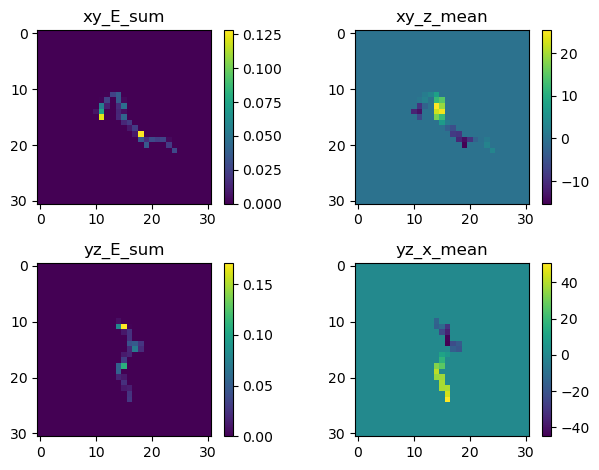

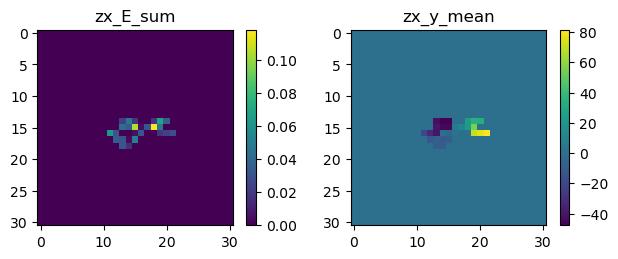

<Figure size 640x480 with 0 Axes>

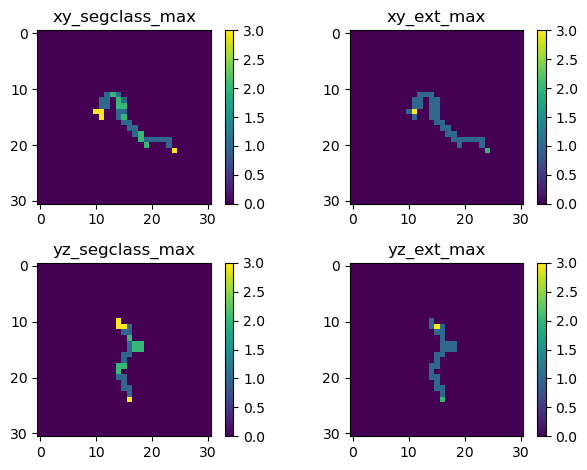

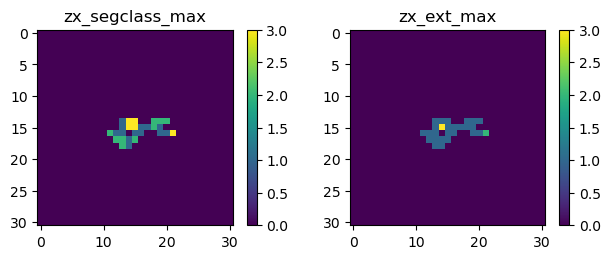

<Figure size 640x480 with 0 Axes>

In [27]:
i = 3
dp.plot_godata(godata, i)

In [39]:
labels = ['xy_segclass_max'] 
black  = True
idata  = cnn.GoDataset(ifile, labels)

index  0 target  1 , id 1922 5
length  41 , sum  56.0 , mean  1.3658536585365855 , std 0.6898602743283391
index  1 target  0 , id 37 24
length  21 , sum  34.0 , mean  1.619047619047619 , std 0.6529194857524805


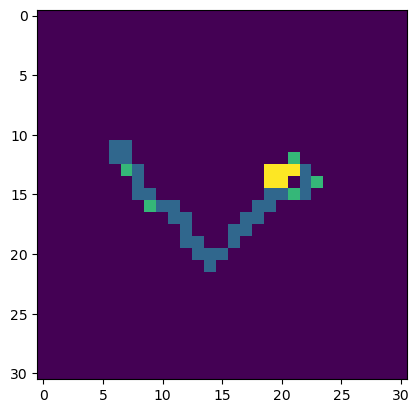

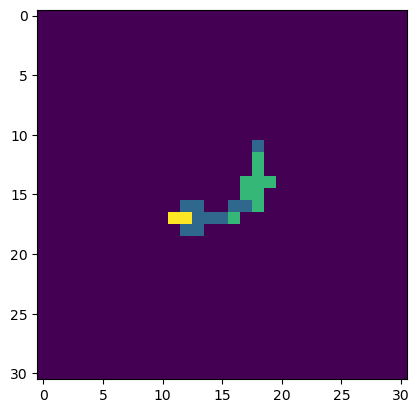

In [44]:
for i in range(2): plot_dset(idata, i)

In [43]:
shuffle = True
np.random.shuffle(idata.y)

In [45]:
size, depth, width, _ = idata.x.shape
expansion =   4
nepochs   =   4
kernel    =   3
kcnn  = cnn.HCNN(depth, width, expansion = expansion, kernel = kernel)

int conv : width =  31
1st conv : width =  31 , kernel =  15
2nd conv : width =  19 , kernel =  9
3rd conv : width =  13 , kernel =  6
4th conv : width =  10 , kernel =  5
out conv : width =  8


In [46]:
cnn_name = 'test_hcnn'
ofile    = 'test.npz'
print(ofile)
config = cnn.config
config['loss_function'] = 'CrossEntropyLoss'
config['learning_rate'] = 0.001
box  = cnn.run(idata, kcnn, ofilename = ofile, nepochs = nepochs, config = config)

test.npz
Dataset : 
   labels   : ['xy_segclass_max']
   x shape  : (213472, 1, 31, 31)
   y shape  : (213472,)
   black    : False
   scale    : 1.0
{'loss_function': 'CrossEntropyLoss', 'learning_rate': 0.001}
Event Image sample :  (213472, 1, 31, 31)
Using cpu device 
HCNN(
  (conv1): Conv2d(1, 4, kernel_size=(15, 15), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(4, 8, kernel_size=(9, 9), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 16, kernel_size=(6, 6), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc0): Linear(in_features=2048, out_features=2, bias=True)
  

In [47]:
box = np.load(ofile)

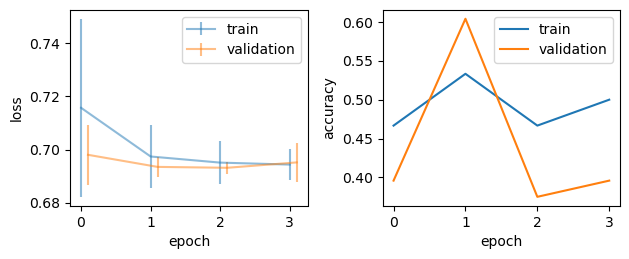

In [49]:
cnn.plot_epochs(box['losses'], box['accuracies'])

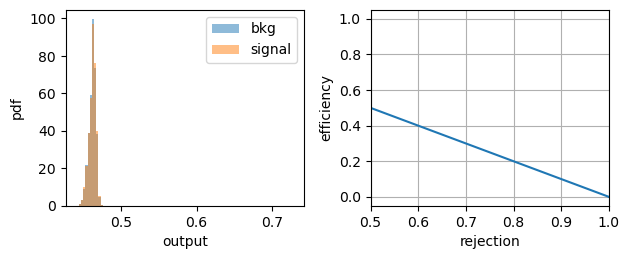

In [50]:
cnn.plot_roc(box['y'], box['yp'])

target  [1.]


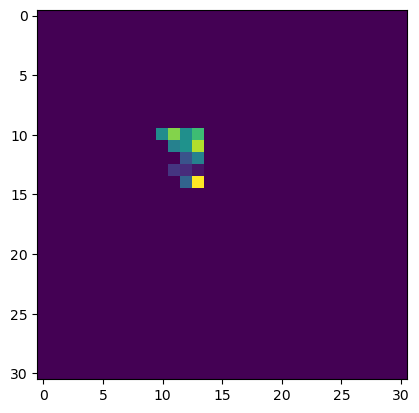

In [72]:
xi, yi = dset0[index]
print('target ', yi.numpy())
plt.imshow(xi.numpy()[0])

index  0 target  [0] , id [[720]
 [  9]]
length  29 , sum  1.0 , mean  0.034482758620689655 , std 0.03480857125396073
index  0 target  0 , id [1922    5]
length  41 , sum  0.9209129763370794 , mean  0.022461292105782422 , std 0.021997425075316827


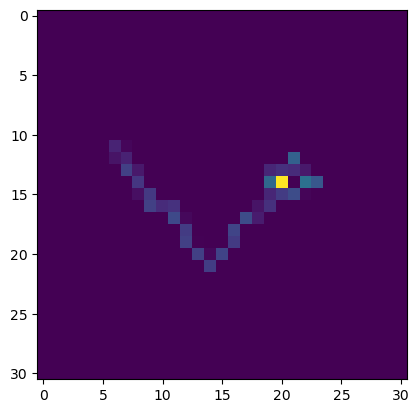

In [55]:
dset0 = cc[0][0]
dset1 = cc[1][0]
    
ievt = 0
plot_dset(dset0, ievt)
plot_dset(dset1, ievt)


In [7]:
ifile2 = ipath + 'shots/' + '5bar_shuffle_s0mm_w10mm.npz'
idata2 = dp.godata_load(ifile2)

y   0
id  [703  20]


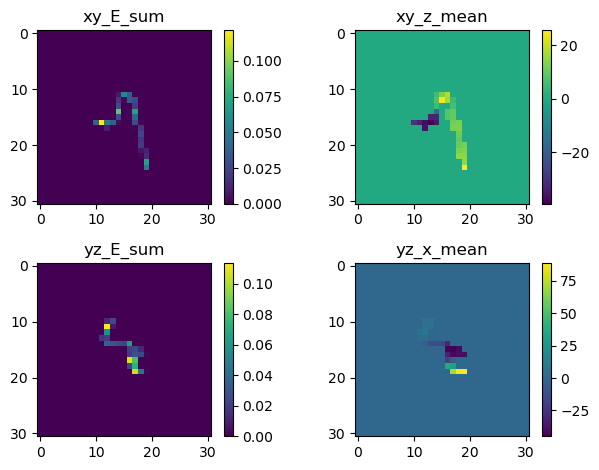

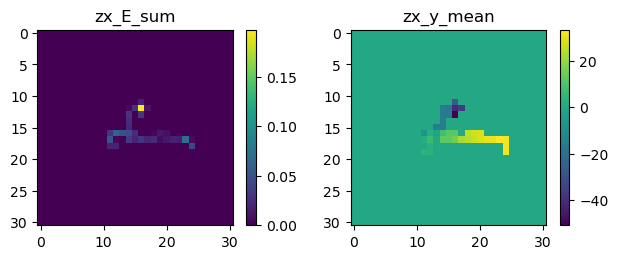

<Figure size 640x480 with 0 Axes>

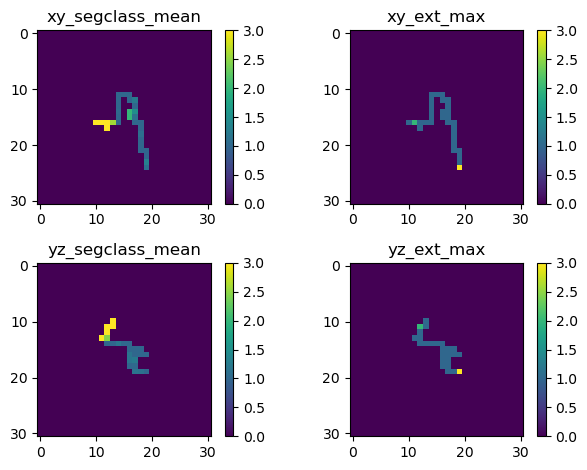

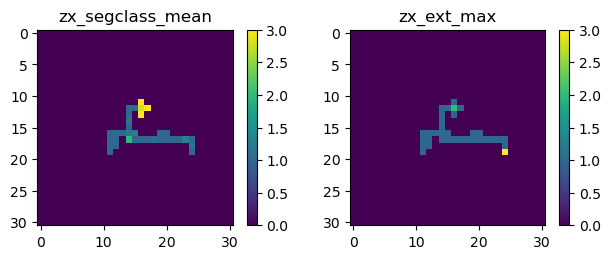

<Figure size 640x480 with 0 Axes>

In [21]:
dp.plot_godata(idata2, 0)

In [2]:
maska = (idata1.y == 1)

NameError: name 'idata1' is not defined

In [17]:
idata2.id[60]

array([172,  58])

In [25]:
m, n = 2, 10
k, f = 4, 2

mycc = cnn.ExtGoCNN(m, n, k, f)

 Conv  : [ 2 ,  10 ] -> [ 4 ,  7 ], ndim =  196 , k =  4
 Conv  : [ 4 ,  7 ] -> [ 8 ,  4 ], ndim =  128 , k =  4
 Conv  : [ 8 ,  4 ] -> [ 16 ,  3 ], ndim =  144 , k =  2
 Conv  : [ 16 ,  3 ] -> [ 32 ,  2 ], ndim =  128 , k =  2
 Lin   :  128  ->  4
 Lin   :  4  ->  1


## Ana CNN

In [26]:
#path       = os.environ['LPRDATADIR']
#ipath      = path + 'xymm/'
#opath      = path + 'cnn/'
#pressure   = '5bar'
projection = ('x', 'y')
#widths     = (10, 10)
#labels     = ['seg',]

idata, odata = cnn.retrieve_cnn_data(ipath, opath, pressure, projection, widths, labels, cnn_name = cnn_name)

data file :  /scratch/next/data/NEXT100/pressure_topology/xymm/xymm_13bar_xy_10x10_100.npz
cnn file  : temp//temp_cnn_esum_xymm_13bar_xy_10x10_100.npz


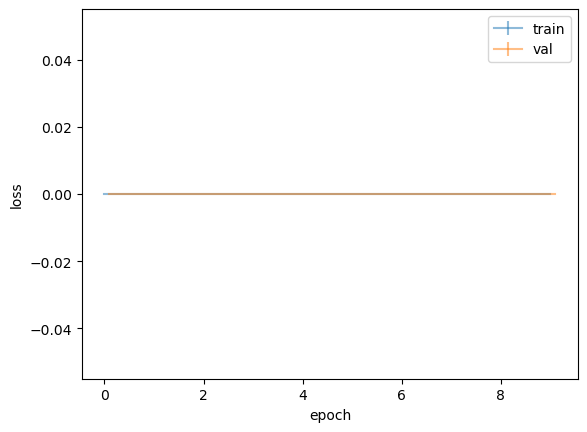

In [27]:
cnn.plot_epochs(odata['epochs'])

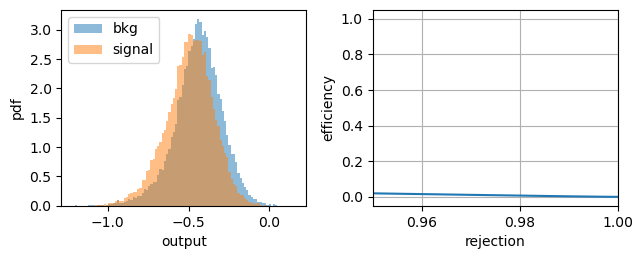

In [28]:
cnn.plot_roc(odata['y'], odata['yp'], 0.95)

event  154094
target test       1
target test pred  0.9983534216880798
success           True
total     test 1.0


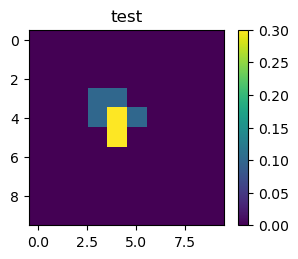

In [22]:
cnn.plot_event(idata, odata, labels)